/bin/sh: 1: pip: not found
Files already downloaded and verified


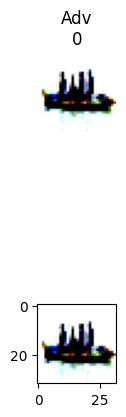

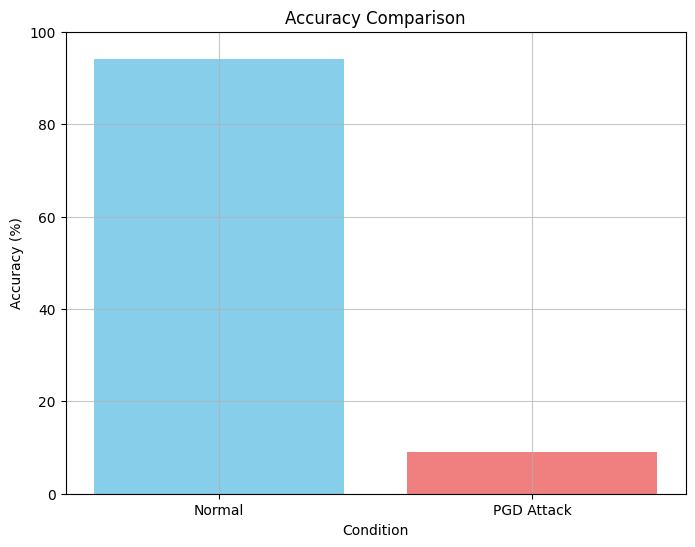

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

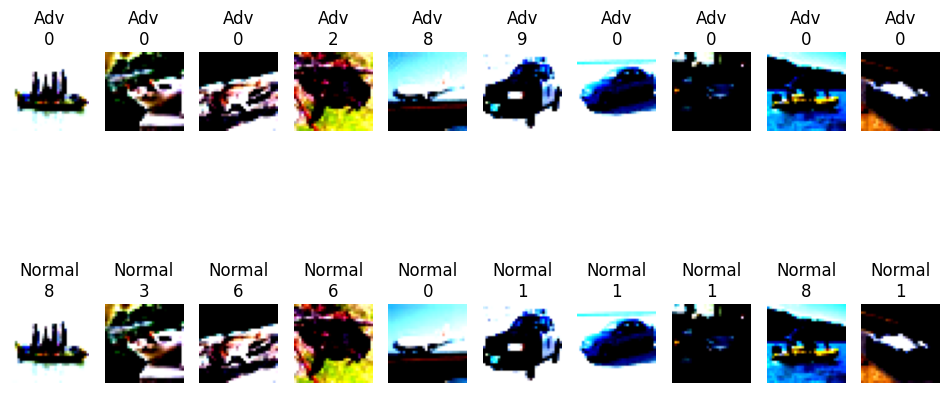

正常准确率: 94.02%
PGD 攻击后准确率: 9.09%


In [6]:
# 安装所需的包
!pip install pytorchcv matplotlib

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from pytorchcv.model_provider import get_model as ptcv_get_model
import matplotlib.pyplot as plt

# 设置运行设备，优先使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练的ResNet-20模型，该模型已在CIFAR-10数据集上训练好
model = ptcv_get_model("resnet20_cifar10", pretrained=True)
model = model.to(device)  # 将模型移动到指定设备上
model.eval()  # 设置模型为评估模式，关闭Dropout等操作

# 定义CIFAR-10测试集的数据预处理方式
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为Tensor，并归一化到[0, 1]
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # 按通道标准化
                         std=[0.2023, 0.1994, 0.2010])
])
# 下载并加载CIFAR-10测试集
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# 实现PGD攻击函数
def pgd_attack(model, images, labels, eps=8/255, alpha=2/255, iters=10):
    images = images.clone().detach().to(device)  # 克隆图像张量，避免修改原始数据
    labels = labels.to(device)
    original_images = images.clone().detach()  # 保存原始图像
    loss_fn = nn.CrossEntropyLoss()  # 使用交叉熵损失函数

    for i in range(iters):  # 进行多步梯度下降
        images.requires_grad = True  # 开启梯度计算
        outputs = model(images)      # 前向传播
        loss = loss_fn(outputs, labels)  # 计算损失
        model.zero_grad()            # 清空梯度
        loss.backward()              # 反向传播获取梯度
        # 按照梯度符号方向更新图像，生成对抗样本
        adv_images = images + alpha * images.grad.sign()
        # 将扰动限制在ε范围内（L∞范数约束）
        eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)
        # 确保图像像素值在[0, 1]范围内
        images = torch.clamp(original_images + eta, min=0, max=1).detach()

    return images

# 计算正常情况下的准确率
model.eval()  # 确保模型处于评估模式
correct_normal = 0
total_normal = 0
with torch.no_grad():  # 在评估过程中不需要计算梯度
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)  # 获取预测标签
        total_normal += labels.size(0)
        correct_normal += (predicted == labels).sum().item()  # 统计正确预测的数量

accuracy_normal = 100 * correct_normal / total_normal  # 计算准确率

# 执行PGD攻击并评估模型在对抗样本上的准确率
correct_adv = 0
total_adv = 0
for images, labels in testloader:
    adv_images = pgd_attack(model, images, labels)  # 生成对抗样本
    with torch.no_grad():
        outputs = model(adv_images)
        _, predicted = outputs.max(1)
        total_adv += labels.size(0)
        correct_adv += (predicted.cpu() == labels).sum().item()  # 统计正确预测的数量

accuracy_adv = 100 * correct_adv / total_adv  # 计算对抗样本下的准确率

# 绘制准确率对比图
labels_acc = ['Normal', 'PGD Attack']
accuracies = [accuracy_normal, accuracy_adv]
plt.figure(figsize=(8, 6))
plt.bar(labels_acc, accuracies, color=['skyblue', 'lightcoral'])
plt.xlabel('Condition')  # X轴标签
plt.ylabel('Accuracy (%)')  # Y轴标签
plt.title('Accuracy Comparison')  # 图表标题
plt.ylim(0, 100)
plt.grid(True, alpha=0.7)
plt.show()

# 绘制对抗样本示例
plt.figure(figsize=(12, 6))
for i in range(10):  # 绘制前10个样本
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(adv_images[i].cpu().permute(1, 2, 0))  # 显示对抗样本
    plt.title(f"Adv\n{predicted[i].item()}")
    plt.axis('off')

    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(images[i].cpu().permute(1, 2, 0))  # 显示原始样本
    plt.title(f"Normal\n{labels[i].item()}")
    plt.axis('off')

plt.show()

# 输出攻击后的准确率
print(f"正常准确率: {accuracy_normal:.2f}%")
print(f"PGD攻击后准确率: {accuracy_adv:.2f}%")